In [1]:
import numpy as np
import elboflow as ef
import tensorflow as tf
import scipy.stats
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
%matplotlib inline

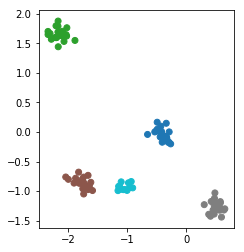

In [2]:
# Generate some data for mixtures
np.random.seed(2)
num_samples = 100
num_dims = 2
num_components = 5

component_means = np.random.normal(0, 1, (num_components, num_dims))
component_precisions = np.random.gamma(100, 1, (num_components, num_dims))
z = np.random.randint(num_components, size=num_samples)
x = component_means[z] + np.random.normal(0, 1, (num_samples, num_dims)) / np.sqrt(component_precisions[z])

fig, ax = plt.subplots(1, 1)
ax.scatter(*x.T, c=z, cmap='Vega10')
ax.set_aspect('equal')

In [3]:
# Construct a graph
with tf.Graph().as_default() as graph:
    # Define the factors
    q_mu = ef.MultiNormalDistribution(
        ef.get_variable('mu_mean', (1, num_components, num_dims)),
        ef.get_positive_definite_variable('mu_precision', (1, num_components, num_dims, num_dims))
    )
    q_tau = ef.WishartDistribution(
        ef.get_positive_variable('tau_dof', (1, num_components)) + float(num_dims - 1),
        ef.get_positive_definite_variable('tau_scale', (1, num_components, num_dims, num_dims)),
    )
    q_z = ef.CategoricalDistribution(
        ef.get_normalized_variable('z_p', (num_samples, num_components))
    )
    
    log_normal_likelihood = ef.MultiNormalDistribution.log_likelihood(x[:, None, :], q_mu, q_tau)
    log_mixture_likelihood = ef.CategoricalDistribution.mixture_log_likelihood(q_z, log_normal_likelihood)
    log_joint = tf.reduce_sum(log_mixture_likelihood) + \
        tf.reduce_sum(ef.NormalDistribution.log_likelihood(q_mu, 0.0, 1e-3)) + \
        tf.reduce_sum(ef.WishartDistribution.log_likelihood(q_tau, 2.0, 1e-3 * np.eye(num_dims))) + \
        tf.reduce_sum(ef.CategoricalDistribution.log_likelihood(q_z, np.ones((1, num_components), np.float32) / num_components))
    entropy = tf.reduce_sum(q_mu.entropy) + tf.reduce_sum(q_tau.entropy) + tf.reduce_sum(q_z.entropy)
    elbo = log_joint + entropy
    
    # Add a training operation
    train_op = tf.train.AdamOptimizer(0.1).minimize(-elbo)
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
sess.run(elbo)

-2380.5212

Widget Javascript not detected.  It may not be installed or enabled properly.


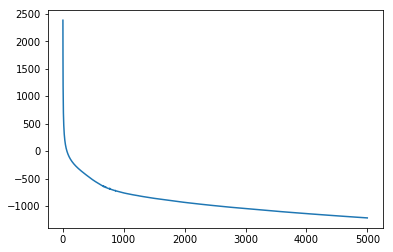

In [4]:
# Maximize the ELBO
elbos = []
precisions = []

for _ in tqdm_notebook(range(5000)):
    _, _elbo, _precision = sess.run([train_op, elbo, q_tau.statistic(1)])
    elbos.append(_elbo)
    precisions.append(_precision)
    
plt.plot(-np.asarray(elbos))

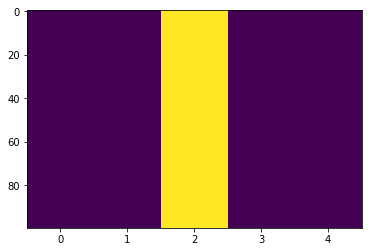

In [5]:
plt.imshow(sess.run(q_z.mean), aspect='auto')